In [12]:
%matplotlib ipympl
import numpy as np
from numba import jit, vectorize, float64, types
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

In [23]:
# Coupling formula
alpha = 1

a = 0.3
b = 0.3
c = 0.5

@vectorize([float64(float64, float64, float64)])
def compute_coupling(x, y, z):
    if (x, y, z) == (0,0,0):
         return np.nan
    return alpha/(a*x**2 + b*y**2 + c*z**2)**2*np.abs(3*c*z**2/(a*x**2 + b*y**2 + c*z**2) - 1)


# State generation

In [24]:
def generate_lattice_sites(n, max_cell = 5):
    # TODO: Improve using random picking
    return np.unique(np.random.randint(max_cell, size=(n, 3)), axis = 0)

def add_noise(couplings, sigma):
    return np.max(0, couplings + np.random.normal(scale = sigma, size = couplings.shape))

@jit
def couplings(sites):
    n = sites.shape[0]
    couplings = np.full((n , n), np.nan)
    for i in range(sites.shape[0]-1):
        for j in range(i+1, sites.shape[0]):
            x = sites[i][0] - sites[j][0]
            y = sites[i][1] - sites[j][1]
            z = sites[i][2] - sites[j][2]
            couplings[i, j] = compute_coupling(x, y, z)
    return couplings

In [25]:
test_sites = generate_lattice_sites(25, max_cell=2)

In [26]:
test_couplings = couplings(test_sites)

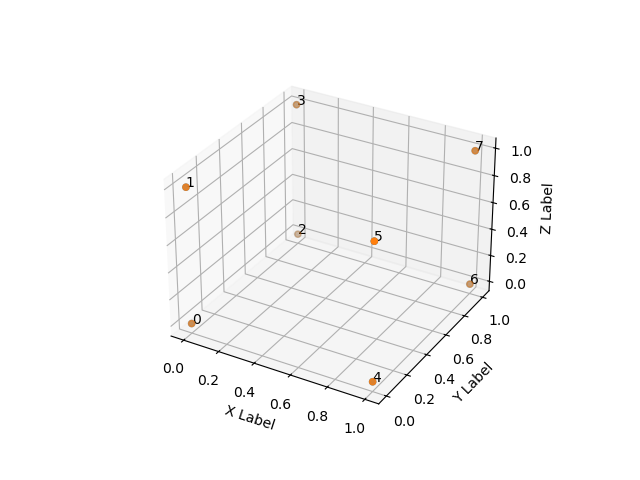

In [27]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(test_sites[:,0], test_sites[:,1], test_sites[:,2])
ax.scatter(test_sites[:,0], test_sites[:,1], test_sites[:,2])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

for i in range(test_sites.shape[0]):
    ax.text(test_sites[i,0], test_sites[i,1], test_sites[i,2], str(i))

# State reconstruction

In [28]:
tolerance = 1

@jit
def index_to_coord(index, max_distance):
    center = max_distance // 2
    return (index // max_distance**2 - center, index // max_distance % max_distance - center, index % max_distance - center)  

@jit
def coord_to_index(vec, max_distance):
    center = max_distance // 2
    return (vec[0] + center)*max_distance**2 + (vec[1] + center) * max_distance + (vec[2] + center)

#@jit #(locals={'current_set': types.Set(types.UniTuple(float64, 3))})
def vector_couplings(max_distance=10, tolerance = 1):
    print("Computing vector -> couplings lookup")
    couplings = np.empty(max_distance*max_distance*max_distance)
    for i in range(max_distance**3):
        couplings[i] = compute_coupling(
                    *index_to_coord(i, max_distance)
                )
    # Revert the map
    print("Reverting the map")
    coupling_values = [] # OK to append because O(number_spins)
    current_set = set(((0,0,0),))
    current_set.remove((0,0,0)) # HACK for type inference
    vectors = [current_set.copy()] # OK to append because O(number_spins)
    sorted_couplings = np.argsort(couplings)
    # i_max = coupling index st coupling + tolerance < cureent cursor
    # i_min = coupling index st coupling - tolerance < cureent cursor
    i_min, i_max = 0,0
    while not np.isnan(couplings[sorted_couplings[i_max]]):
        if np.isnan(couplings[sorted_couplings[i_min]]) or couplings[sorted_couplings[i_min]] - tolerance > couplings[sorted_couplings[i_max]] + tolerance:
            # Depile du côté des maxima (ie on retire un vecteur au set)
            vec = index_to_coord(sorted_couplings[i_max], max_distance)
            current_set.remove(vec) # We want unmutable type here
            coupling_values.append(couplings[sorted_couplings[i_max]] + tolerance)
            i_max += 1
        else:
            # Depile du côté des minima (ie on ajoute un vecteur au set)
            vec = index_to_coord(sorted_couplings[i_min], max_distance)
            current_set.add(vec) # We want unmutable type here
            coupling_values.append(couplings[sorted_couplings[i_min]] - tolerance)
            i_min += 1
        vectors.append(current_set.copy())
    return np.array(coupling_values), vectors

In [29]:
@jit
def cost_function(sites, couplings):
    couplings_theory = couplings(sites)
    cost = 0
    for i in range(sites.shape[0]-1):
        for j in range(i+1, sites.shape[0]):
            if np.isnan(couplings[i,j]):
                continue
            x = sites[i][0] - sites[j][0]
            y = sites[i][1] - sites[j][1]
            z = sites[i][2] - sites[j][2]
            cost += (couplings[i,j] - compute_coupling(x, y, z))**2
    return cost

@jit
def t_add(t1, t2):
    return (t1[0] + t2[0], t1[1] + t2[1], t1[2] + t2[2])
    
@jit
def t_sub(t1, t2):
    return (t1[0] - t2[0], t1[1] - t2[1], t1[2] - t2[2])

def compute_sites(couplings, lattice_size = 10, tolerance = 0.01):
    print("Begin")
    n_placed = 1
    n_tot = couplings.shape[0]
    couplings_vectors_tup = vector_couplings(tolerance = tolerance, max_distance = lattice_size*2) # TODO better names
    possible_configurations = [np.zeros((n_tot, 3), dtype=np.int64)]

    
    current_couplings = np.empty(n_tot) # stores current coupling

    print("Initialization successful")
    while n_placed < n_tot:
        print(f"Placing {n_placed}")
        # First place them in order
        n_to_place = n_placed

        for i in range(n_tot):
            current_couplings[i] = np.nanmax([couplings[n_to_place, i], couplings[i, n_to_place]])
        print(current_couplings)
        # Be careful, position relative to n_to_place-1
        candidates = couplings_vectors_tup[1][np.searchsorted(couplings_vectors_tup[0], current_couplings[n_to_place-1])]
        print(candidates)
        new_possible_configurations = []
        for config in tqdm(possible_configurations):
            for candidate in candidates:
                good_candidate = True
                for i in range(n_placed):
                    if np.isnan(current_couplings[i]):
                        # no data for the already placed spin
                        continue
                    coupling_candidate = compute_coupling(*t_sub(config[i], t_add(candidate, config[n_to_place-1])))
                    if np.isnan(coupling_candidate) or np.abs(current_couplings[i] - coupling_candidate) > tolerance: # TODO: One redundant check
                        good_candidate = False
                        break
                if good_candidate:
                    new_config = config.copy()
                    new_config[n_to_place] = np.array(t_add(candidate, config[n_to_place-1]))
                    new_possible_configurations.append(new_config)
        possible_configurations = new_possible_configurations
        n_placed+=1
    return possible_configurations


In [30]:
final_configs = compute_sites(test_couplings, tolerance = 0.005)

Begin
Computing vector -> couplings lookup
Reverting the map
Initialization successful
Placing 1
[ 8.                 nan  1.3671875  11.11111111  1.3671875  11.11111111
  0.30052592  2.77777778]
{(0, 0, -1), (0, 0, 1)}


/tmp/ipykernel_35830/924063087.py:40: RuntimeWarning: All-NaN axis encountered
  current_couplings[i] = np.nanmax([couplings[n_to_place, i], couplings[i, n_to_place]])


  0%|          | 0/1 [00:00<?, ?it/s]

Placing 2
[11.11111111  1.3671875          nan  8.          2.77777778  0.30052592
 11.11111111  1.3671875 ]
{(0, -1, -1), (1, 0, 1), (-1, 0, 1), (0, -1, 1), (1, 0, -1), (-1, 0, -1), (0, 1, -1), (0, 1, 1)}


/tmp/ipykernel_35830/924063087.py:40: RuntimeWarning: All-NaN axis encountered
  current_couplings[i] = np.nanmax([couplings[n_to_place, i], couplings[i, n_to_place]])


  0%|          | 0/2 [00:00<?, ?it/s]

Placing 3
[ 1.3671875  11.11111111  8.                 nan  0.30052592  2.77777778
  1.3671875  11.11111111]
{(0, 0, -1), (0, 0, 1)}


  0%|          | 0/8 [00:00<?, ?it/s]

Placing 4
[11.11111111  1.3671875   2.77777778  0.30052592         nan  8.
 11.11111111  1.3671875 ]
{(0, -1, -2), (-1, 1, -1), (-1, 1, 1), (-1, 0, -2), (1, -1, 1), (1, -1, -1), (0, 1, -2), (-1, 0, 2), (0, -1, 2), (1, 0, -2), (-1, -1, -1), (-1, -1, 1), (0, 1, 2), (1, 1, -1), (1, 0, 2), (1, 1, 1)}


  0%|          | 0/8 [00:00<?, ?it/s]

Placing 5
[ 1.3671875  11.11111111  0.30052592  2.77777778  8.                 nan
  1.3671875  11.11111111]
{(0, 0, -1), (0, 0, 1)}


  0%|          | 0/16 [00:00<?, ?it/s]

Placing 6
[ 2.77777778  0.30052592 11.11111111  1.3671875  11.11111111  1.3671875
         nan  8.        ]
{(0, -1, -1), (1, 0, 1), (-1, 0, 1), (0, -1, 1), (1, 0, -1), (-1, 0, -1), (0, 1, -1), (0, 1, 1)}


  0%|          | 0/16 [00:00<?, ?it/s]

Placing 7
[ 0.30052592  2.77777778  1.3671875  11.11111111  1.3671875  11.11111111
  8.                 nan]
{(0, 0, -1), (0, 0, 1)}


  0%|          | 0/16 [00:00<?, ?it/s]

In [31]:
len(final_configs)

16

/tmp/ipykernel_35830/4115954874.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


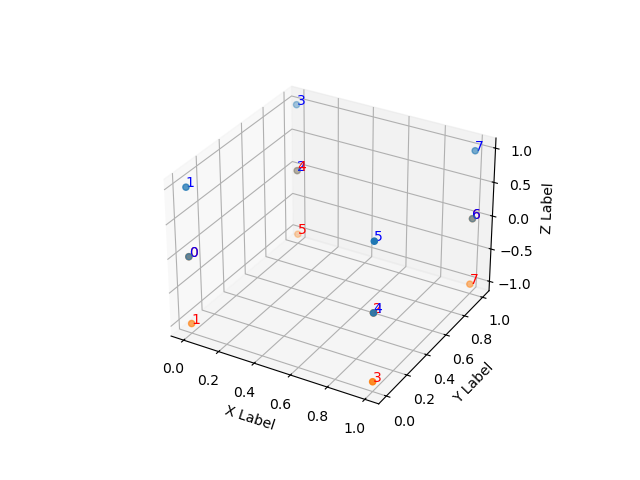

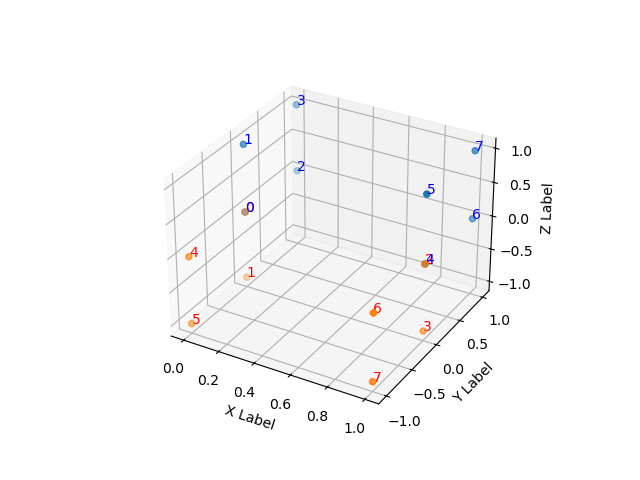

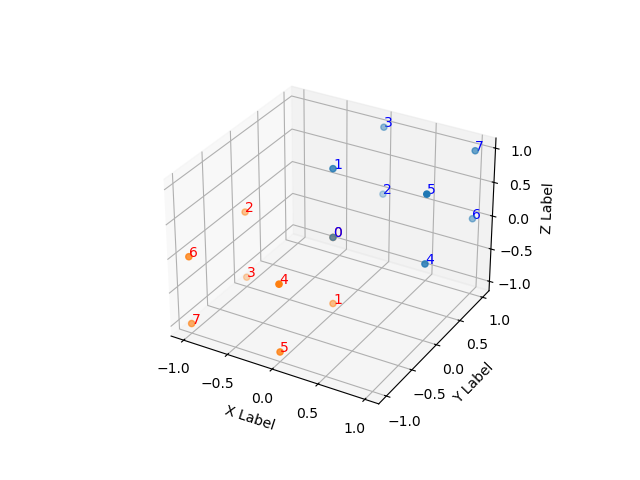

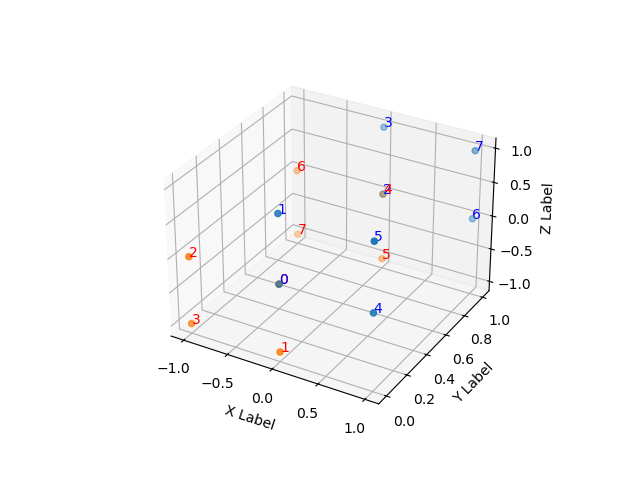

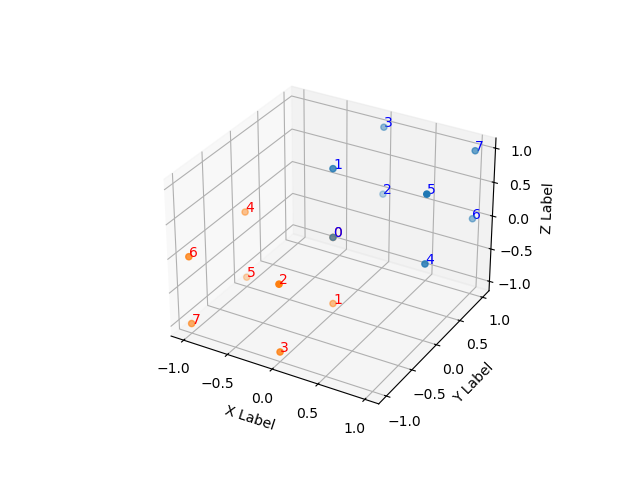

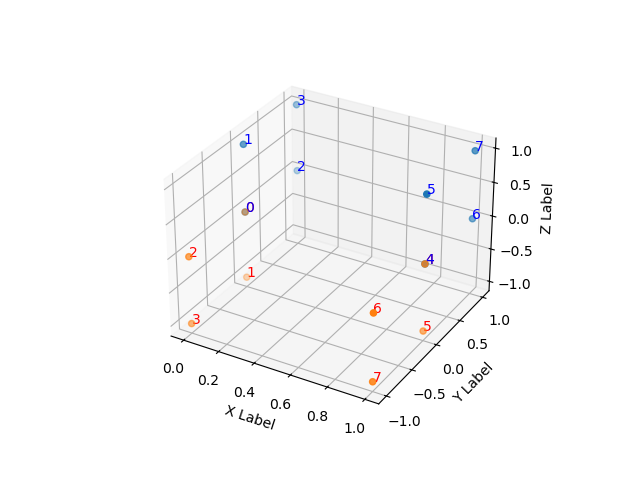

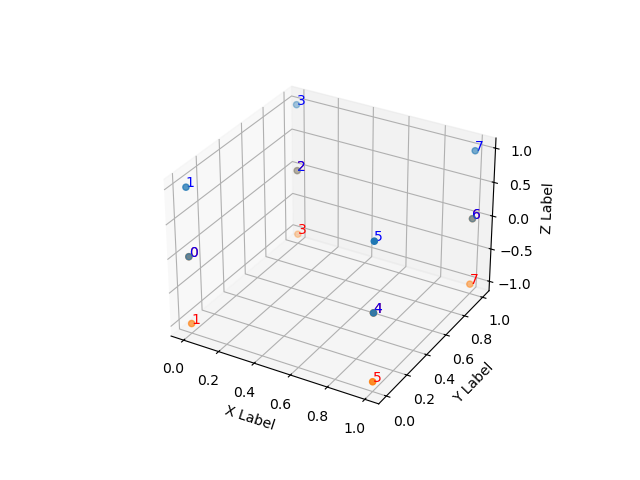

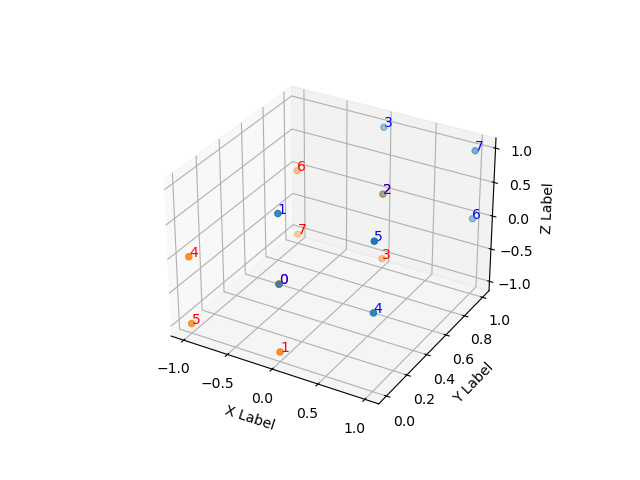

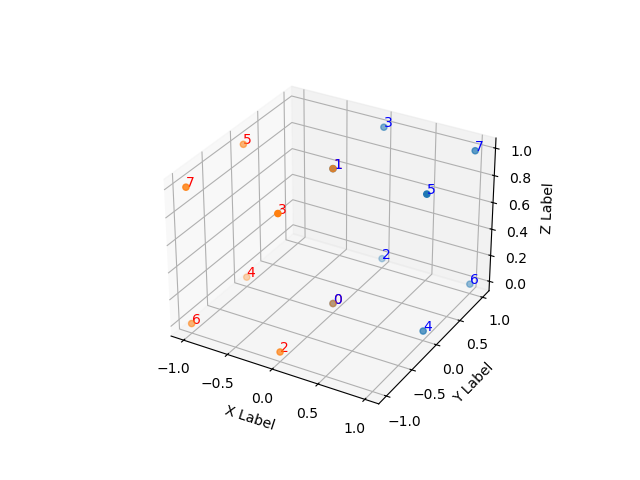

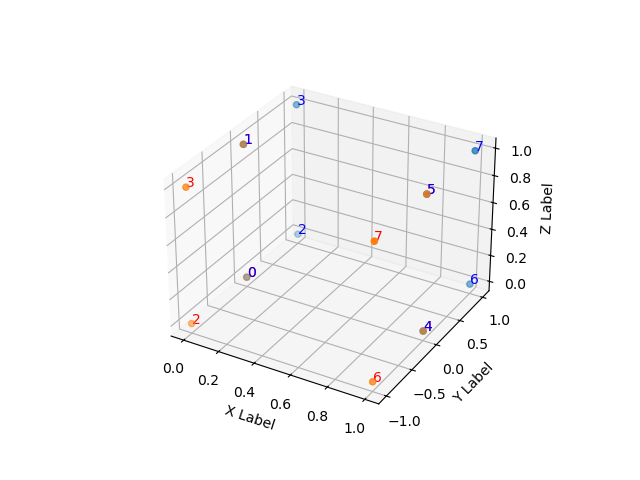

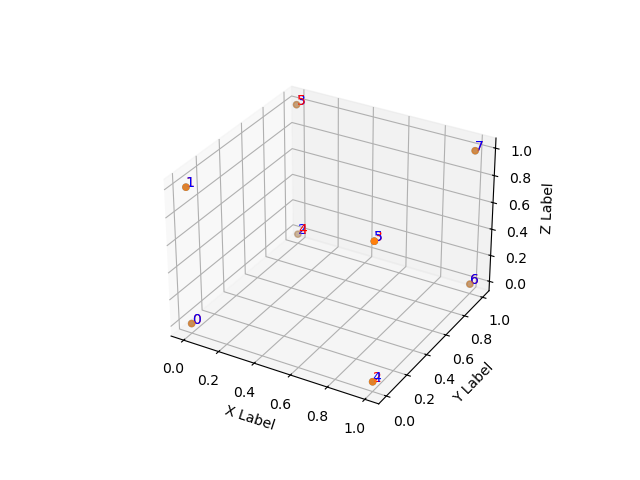

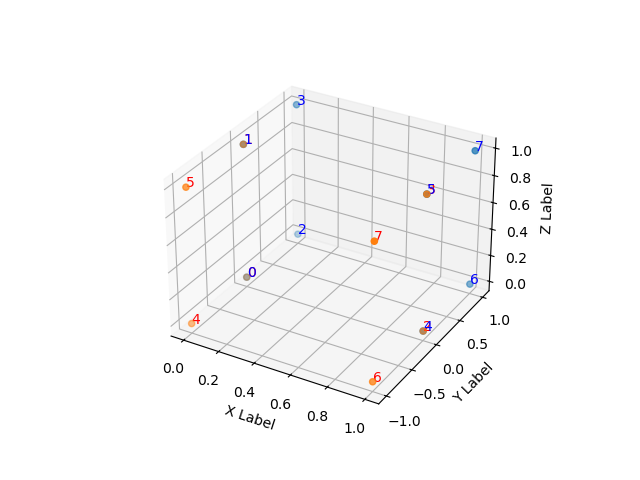

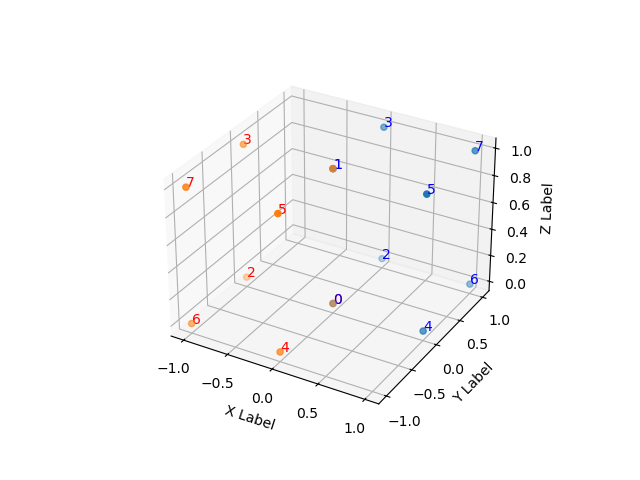

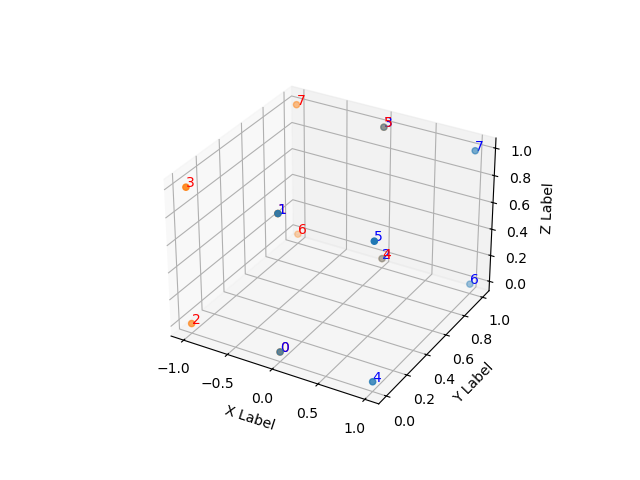

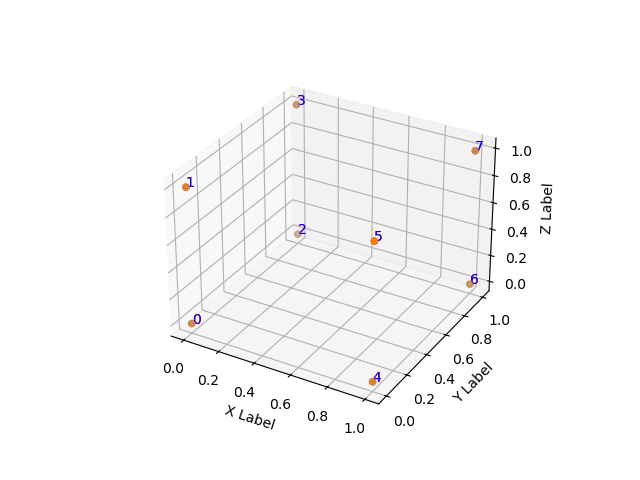

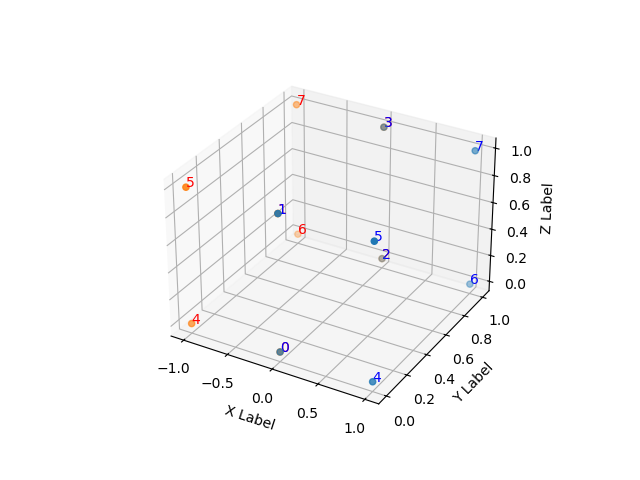

In [32]:
for j in range(len(final_configs)):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    final_config = final_configs[j]
    ax.scatter(test_sites[:,0], test_sites[:,1], test_sites[:,2])
    
    ax.scatter(final_config[:,0], final_config[:,1], final_config[:,2])
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    for i in range(final_config.shape[0]):
        ax.text(final_config[i,0], final_config[i,1], final_config[i,2], str(i), color="red")
        ax.text(test_sites[i,0], test_sites[i,1], test_sites[i,2], str(i), color="blue")